In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    """
    For a given observation, compute Q values for each action
        Attributes
    ----------
    lr: float
        learning rate
    input_dims : list
        [8]
    fc1_dims : int
        fully-connected layer 1
    fc2_dims : int
        fully-connected layer 2
    n_actions : int
        the number of actions
    """
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, weight_decay=1e-5, p=0.1):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.dropout = nn.Dropout(p) 
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.loss = nn.MSELoss()
        self.loss = nn.SmoothL1Loss() # Huber loss
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.dropout(x) # dropout for regularization
        actions = self.fc3(x)
        
        return actions

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                max_mem_size=100000, eps_end=0.01, eps_dec=1e-5, weight_decay=1e-5):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)] # list of actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, 
                                  fc1_dims=64, fc2_dims=64, weight_decay=weight_decay)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype= np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # residual. The memory is finite, so we are reusing
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] =  action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
        
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device) # [] is used because of the nn library. torch.Size([1, 6])
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item() # .item() to get integer
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.train()
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size) 
        # select samples the number of self.batch_size out of max_mem 
        batch = np.random.choice(max_mem, self.batch_size, replace=False) # Don't select the same thing again
        # array slicing [0,1,2,...,self.batch_size-1]
        batch_index = np.arange(self.batch_size, dtype=np.int32) 
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
                                                 
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        T.nn.utils.clip_grad_norm_(self.Q_eval.parameters(), 1.0) # gradient clip
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        

In [2]:
#from env import TradingSPYEnv
#from env2 import TradingSPYEnv
from env6 import TradingSPYEnv
import numpy as np
import os
state_dict_path = os.path.join(os.getcwd(),'test6.pth')
best_state_dict_path = os.path.join(os.getcwd(),'best6.pth')
env = TradingSPYEnv(init_invest=100.0, sma_len=[5,10,15,20,25],train_test_split=0.5)
#num_states = len(env.reset())
num_states = env.reset(50).shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))

agent = Agent(gamma=0.99, epsilon=1.0, batch_size=4096, n_actions=num_actions, eps_end=0.01, input_dims = [num_states], lr=0.0003,
              weight_decay=1e-5)
#agent.Q_eval.load_state_dict(T.load(state_dict_path))
scores, eps_history = [], []
n_games = 1000
max_score = 0.0


for i in range(n_games):
    score = 0.0
    done = False
    observation = env.reset(50)
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        if (observation_ is not None): 
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    
    avg_score = np.mean(scores[-100:])
    
    print('episode ', i, 'score %.2f' % score,
         'average score %.2f' % avg_score,
         'epsilon %.2f ' % agent.epsilon,
         'profit_iteration %.2f ' % info['profit_iteration'],
         'iterations %.2f ' % info['iterations'],
         'long_return %.2f ' % info['long_return']
         )
    
    if i % 50 == 0:
        T.save(agent.Q_eval.state_dict(), state_dict_path)
        print("saved check point")
    if score > max_score:
        max_score = score
        T.save(agent.Q_eval.state_dict(), best_state_dict_path)
        print("saved best parameters")


C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Size of State Space ->  200
Size of Action Space ->  3
episode  0 score -27.44 average score -27.44 epsilon 1.00  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
saved check point
episode  1 score -40.06 average score -33.75 epsilon 0.99  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  2 score 6.33 average score -20.39 epsilon 0.97  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
saved best parameters
episode  3 score -18.24 average score -19.85 epsilon 0.95  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  4 score 34.62 average score -8.96 epsilon 0.93  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
saved best parameters
episode  5 score -33.21 average score -13.00 epsilon 0.90  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  6 score -24.43 average score -14.63 epsilon 0.88  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  7 score 175.99 average score 9.20 epsi

episode  68 score -23.96 average score 10.43 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  69 score -18.06 average score 10.03 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  70 score -34.36 average score 9.40 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  71 score 28.07 average score 9.66 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  72 score 84.60 average score 10.69 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  73 score -54.42 average score 9.81 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  74 score -51.99 average score 8.98 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  75 score -73.27 average score 7.90 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  76 score 5.08 average score 7.87 epsil

episode  137 score 3.69 average score -1.83 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  138 score 6.15 average score -1.60 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  139 score -15.49 average score -2.35 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  140 score -23.44 average score -2.73 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  141 score -2.12 average score -2.83 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  142 score 40.11 average score -2.40 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  143 score -22.30 average score -2.93 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  144 score 74.35 average score -2.06 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  145 score -38.03 average score

episode  204 score -20.32 average score 36.29 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  205 score 27.39 average score 36.80 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  206 score 1.62 average score 36.47 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  207 score 14.89 average score 36.37 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  208 score -36.38 average score 36.75 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  209 score 11.33 average score 36.82 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  210 score -38.66 average score 36.53 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  211 score -10.56 average score 37.03 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  212 score 62.20 average scor

episode  272 score 135.92 average score 32.06 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  273 score 96.69 average score 31.37 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  274 score 64.36 average score 30.61 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  275 score 31.63 average score 29.57 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  276 score 100.53 average score 30.83 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  277 score 7.92 average score 31.23 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  278 score 75.93 average score 31.66 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  279 score 27.03 average score 32.03 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  280 score 83.89 average score 

episode  340 score 140.15 average score 53.21 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  341 score -37.00 average score 51.63 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  342 score 41.77 average score 51.32 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  343 score 3.23 average score 50.20 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  344 score -41.99 average score 50.00 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  345 score -28.01 average score 49.61 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  346 score -3.56 average score 49.13 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  347 score 27.98 average score 49.52 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  348 score 5.36 average score

episode  408 score 138.76 average score 36.33 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  409 score 31.98 average score 36.27 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  410 score 60.56 average score 36.55 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  411 score 193.39 average score 38.76 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  412 score 32.06 average score 39.00 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  413 score 196.30 average score 41.34 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  414 score 0.01 average score 41.56 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  415 score 83.98 average score 42.62 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  416 score 58.52 average score

episode  477 score 13.06 average score 35.07 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  478 score 51.49 average score 35.52 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  479 score -7.10 average score 35.14 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  480 score -44.74 average score 34.59 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  481 score 107.64 average score 35.70 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  482 score -2.38 average score 35.43 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  483 score 197.41 average score 37.01 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  484 score 5.07 average score 36.70 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  485 score -11.42 average scor

episode  545 score -7.84 average score 28.97 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  546 score -12.66 average score 29.19 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  547 score 33.07 average score 29.05 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  548 score 118.58 average score 30.18 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  549 score 93.59 average score 30.07 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  550 score 24.93 average score 28.89 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
saved check point
episode  551 score 81.73 average score 29.29 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  552 score -29.88 average score 28.55 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  553 score 

episode  613 score -50.65 average score 60.11 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  614 score 136.35 average score 60.76 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  615 score -38.13 average score 60.43 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  616 score 5.68 average score 60.47 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  617 score 30.33 average score 60.76 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  618 score 114.50 average score 61.23 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  619 score -37.27 average score 59.22 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  620 score -19.93 average score 58.79 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  621 score 44.71 average sc

episode  681 score 80.08 average score 45.76 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  682 score 62.67 average score 45.49 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  683 score 71.16 average score 45.29 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  684 score 30.71 average score 44.97 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  685 score 8.49 average score 44.50 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  686 score 134.93 average score 45.01 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  687 score 113.99 average score 46.12 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  688 score 1.15 average score 46.09 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  689 score 264.64 average score 

episode  749 score -27.83 average score 79.70 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  750 score -2.04 average score 78.72 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
saved check point
episode  751 score -0.08 average score 78.14 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  752 score 144.31 average score 77.91 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  753 score 89.66 average score 78.25 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  754 score 3.98 average score 77.10 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  755 score 72.28 average score 76.94 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  756 score 59.83 average score 77.05 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  757 score 10

episode  817 score 191.12 average score 95.77 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  818 score 120.74 average score 96.75 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  819 score 145.30 average score 97.81 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  820 score 130.56 average score 98.40 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  821 score 35.30 average score 97.94 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  822 score 164.32 average score 98.65 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  823 score 41.06 average score 99.07 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  824 score 40.10 average score 99.00 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  825 score 28.42 average sc

episode  885 score 172.50 average score 96.07 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  886 score 156.03 average score 97.34 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  887 score 144.15 average score 97.46 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  888 score -10.86 average score 96.66 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  889 score 139.23 average score 97.31 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  890 score 84.02 average score 97.20 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  891 score 113.33 average score 98.16 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  892 score 164.20 average score 97.52 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  893 score 251.36 average

episode  953 score 230.66 average score 78.41 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  954 score 29.22 average score 74.75 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  955 score 118.13 average score 74.57 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  956 score -23.09 average score 74.13 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  957 score 69.79 average score 73.76 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  958 score -37.17 average score 72.32 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  959 score 43.74 average score 72.33 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  960 score 122.50 average score 73.12 epsilon 0.01  profit_iteration 0.00  iterations 2298.00  long_return 1.39 
episode  961 score 8.37 average sco

# Save the trained model

In [3]:
import os
state_dict_path = os.path.join(os.getcwd(),'test6.pth')
T.save(agent.Q_eval.state_dict(), state_dict_path)

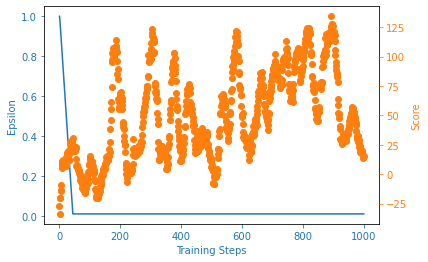

In [4]:
from utils import plot_learning_curve
x = [i+1 for i in range(n_games)]
filename = 'stock_env6.png'
plot_learning_curve(x, scores, eps_history, filename)


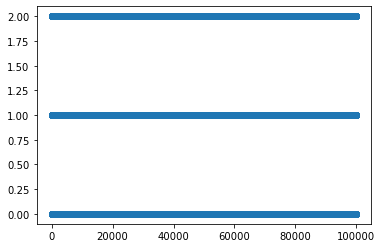

In [5]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(len(agent.action_memory)),agent.action_memory)

In [6]:
agent.Q_eval.load_state_dict(T.load(state_dict_path)) # load saved model

<All keys matched successfully>

In [7]:
print(agent.state_memory[-4:],
        agent.new_state_memory[-4:], 
        agent.action_memory[-4:], 
        agent.reward_memory[-4:], 
        agent.terminal_memory[-4:])

[[ 2.0000000e+00  0.0000000e+00  2.0000000e+00  2.0000000e+00
   0.0000000e+00  2.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  0.0000000e+00  2.0000000e+00  0.0000000e+00
   0.0000000e+00  2.0000000e+00  0.0000000e+00  2.0000000e+00
   0.0000000e+00  0.0000000e+00  2.0000000e+00  1.0000000e+00
   0.0000000e+00  0.0000000e+00  2.0000000e+00  0.0000000e+00
   0.0000000e+00  4.2705345e+01  4.0920055e+01  3.9025837e+01
   3.9796288e+01  4.0042179e+01  3.8968559e+01  3.8920132e+01
   3.9357346e+01  3.8501698e+01  3.8501698e+01  3.7743889e+01
   3.6220528e+01  3.6493675e+01  3.5233540e+01  3.6150162e+01
   3.4773487e+01  3.5346462e+01  3.5548080e+01  3.4791260e+01
   3.4468719e+01  3.4468719e+01  3.3750206e+01  3.3537663e+01
   3.2688843e+01  3.1561686e+01  3.9099525e-03 -1.2510327e-02
   1.3624955e-02  5.5417991e-03  1.7589118e-03  7.7256234e-03
  -3.4847253e-04 -3.1373461e-03  6.1778761e-03 -1.0310473e-02
   5.5015804e-03 -1.1059372e-02 -2.0011771e-03  9.3182353e-03
   6.778

In [8]:
tmp = agent.action_memory[-500:]
print('mean', np.mean(tmp))
print('max', np.max(tmp))
print('min', np.min(tmp))

mean 0.784
max 2.0
min 0.0


# Load Model

In [9]:
from env6 import TradingSPYEnv
import numpy as np
import os
state_dict_path = os.path.join(os.getcwd(),'test6.pth')
best_state_dict_path = os.path.join(os.getcwd(),'best6.pth')
env = TradingSPYEnv(init_invest=100.0, sma_len=[5,10,15,20,25],mode='test',train_test_split=0.5)
#num_states = len(env.reset())
num_states = env.reset(2250).shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))

agent = Agent(gamma=0.99, epsilon=0.0, batch_size=4096, n_actions=num_actions, eps_end=0.0, input_dims = [num_states], lr=0.0001,
              weight_decay=1e-5)
agent.Q_eval.load_state_dict(T.load(state_dict_path))
#agent.Q_eval.load_state_dict(T.load(best_state_dict_path))
agent.Q_eval.eval() # test mode
scores, eps_history = [], []
n_games = 1000
max_score = 0.0


for i in range(n_games):
    score = 0.0
    done = False
    observation = env.reset(2250)
    action_list = []
    while not done:
        action = agent.choose_action(observation)
        action_list.append(action)
        observation_, reward, done, info = env.step(action)
        if (observation_ is not None): 
            score += reward
#            agent.store_transition(observation, action, reward, observation_, done)
#        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    
    avg_score = np.mean(scores[-100:])
    
    print('episode ', i, 'score %.2f' % score,
         'average score %.2f' % avg_score,
         'epsilon %.2f ' % agent.epsilon,
         'profit_iteration %.2f ' % info['profit_iteration'],
         'iterations %.2f ' % info['iterations'],
         'long_return %.2f ' % info['long_return']
         )
#    print(action_list[-20:])
#    print(agent.Q_eval.fc1.weight)
#    raise Exception('spam', 'eggs')

Size of State Space ->  200
Size of Action Space ->  3


C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


episode  0 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  1 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  2 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  3 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  4 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  5 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  6 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  7 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  8 score -70.17 average score -7

episode  68 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  69 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  70 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  71 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  72 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  73 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  74 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  75 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  76 score -70.17 average

episode  136 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  137 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  138 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  139 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  140 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  141 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  142 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  143 score -70.17 average score -70.17 epsilon 0.00  profit_iteration 0.00  iterations 2448.00  long_return 3.45 
episode  144 score -70.1

KeyboardInterrupt: 